# Clustering of Satellite Images with Spark Framework

In [11]:
from osgeo import gdal          #library to convert .tif image to numeric array for computation
from hdfs3 import HDFileSystem  #For using hdfs client directly from python  
import numpy as np              #numeric computation library for python
import matplotlib.pyplot as plt #Data visualization library for python
import pandas as pd             #Data analysis library for python  
from pyspark.sql import SparkSession 
from pyspark.ml.clustering import KMeans
from pyspark import SparkContext
from pyspark.ml.feature import VectorAssembler 
%matplotlib inline
import time





#Connection with hdfs 
hdfs = HDFileSystem(host='localhost', port=9000)


#Reading files from hdfs
with hdfs.open('/usr/data2') as f:
    a= f.read()
    

#Converting the bytes to Array 
image_array_frombytes = np.fromstring(a,dtype=np.uint8)

#Array for keeping the record of individual images
image_array_individual = np.zeros((10,1321,1834),dtype=float)

#Logic for converting the whole array to individual arrays
j=2422714
i=0
index=0
while index <3:
    temp =  image_array_frombytes[i:j]
    image_array_individual[index] = temp.reshape(1321,1834)
    index+=1
    i=j
    j+=2422714

#reshaping array for clustering
image_array_clustering = np.zeros((3,2422714,1),dtype=float)
for i in range(0,3):
    image_array_clustering[i]=image_array_individual[i].reshape(2422714,-1)

    

#Creating a spark context 
spark = SparkSession.builder.appName('imageClustering_multiple').getOrCreate()





#Applying K means clustering
for i in range(0,1):
    t= time.time()
    print(f'dataframe {i+1} creating')
    image_dataframe=pd.DataFrame(data=image_array_clustering[i])
    image_dataframe.head(3)
    image_spark_dataframe = spark.createDataFrame(image_dataframe)#Creating a spark dataframe
    print(f'dataframe {i+1} created {time.time()-t}')
    assembler = VectorAssembler(inputCols= image_spark_dataframe.columns, outputCol='features')
    
    final_d =assembler.transform(image_spark_dataframe)
    print(f'dataframe {i+1} transformed')
    print('clustering...')
    kmean = KMeans(featuresCol='features',k=10)
    model = kmean.fit(final_d)
    cen = model.clusterCenters()
    print(f'Image {i+1}')
    print(f'Cluster centers: {cen}')
    print('Final Predictions')
    model.transform(final_d).select('prediction').show() 
    data_image=model.transform(final_d).select('prediction')
    dip = data_image.toPandas()
    pandas_data=dip.values.reshape(1321,1834)
    plt.imshow(image_array_individual[i])
    plt.imshow(pandas_data,cmap='Accent')
    plt.colorbar()


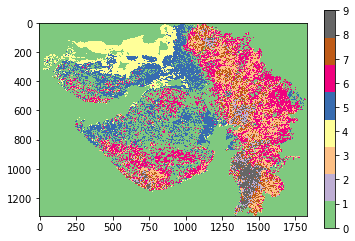

In [13]:
plt.imshow(pandas_data,cmap='Accent')
plt.colorbar()


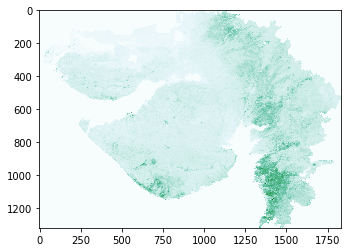